In [1]:
reset -fs

In [2]:
import numpy as np
import pandas as pd
import os
import glob
import dl_functions
from IPython.display import display
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.preprocessing.image import array_to_img, img_to_array
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from skimage import io, color, exposure, transform
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.cross_validation import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline

Using TensorFlow backend.


#### Images we will resized as specified below.

In [3]:
IMG_SIZE = 250

#### Directory where images from epicurious.com will be downloaded.

In [4]:
ok_images='data/downloads/ok'

#### Directory where images from food.com will be downloaded.

In [5]:
nok_images='data/downloads/nok'

#### Creating an array of images already pre-processed and ready to fit a model. Array is normalized.

##### In this case, we normalize the color of images (as we pass the 3rd parameter as `True`).
Note that we stack first the 'good' images, then the 'bad' ones.

In [6]:
X = np.vstack((dl_functions.create_images_array(ok_images, IMG_SIZE, True), dl_functions.create_images_array(nok_images, IMG_SIZE, True)))/255.

/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


#### Creating an array of labels.
Label 1 indicates good image, and 0 bad image. Note that half of the images are good, half are bad, so labels are calculated accordingly.

In [7]:
y = np.vstack((np.array([1]*(len(X)/2)).reshape((len(X)/2), 1), np.array([0]*(len(X)/2)).reshape((len(X)/2), 1)))

#### Creating a train, test split.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### The labels need to be converted to categorical. Note that we have 2 categories: good (1) and bad (0) images.

In [9]:
y_train_sparse = np_utils.to_categorical(y_train, 2)

In [10]:
y_test_sparse = np_utils.to_categorical(y_test, 2)

#### Creating and instance of a CNN model.

In [11]:
model_1 = dl_functions.cnn_model_baseline(IMG_SIZE)

In [12]:
model_1.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [13]:
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 3, 250, 32)        72032     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 248, 32)        9248      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 248, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 248, 64)        18496     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 248, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 248, 128)       73856     
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 248, 128)       0         
__________

In [14]:
model_1.fit(X_train, y_train_sparse, batch_size=128, epochs=20, verbose=1, validation_split=0.3)

Train on 1176 samples, validate on 504 samples
Epoch 1/20
1176/1176 [==============================] - 79s - loss: 6.2666 - acc: 0.5060 - val_loss: 5.2708 - val_acc: 0.5119
Epoch 2/20
1176/1176 [==============================] - 64s - loss: 6.4620 - acc: 0.4847 - val_loss: 7.8672 - val_acc: 0.5119
Epoch 3/20
1176/1176 [==============================] - 61s - loss: 7.1104 - acc: 0.5323 - val_loss: 7.8672 - val_acc: 0.5119
Epoch 4/20
1176/1176 [==============================] - 61s - loss: 7.9555 - acc: 0.5017 - val_loss: 7.8672 - val_acc: 0.5119
Epoch 5/20
1176/1176 [==============================] - 61s - loss: 8.0710 - acc: 0.4983 - val_loss: 7.8672 - val_acc: 0.5119
Epoch 6/20
1176/1176 [==============================] - 61s - loss: 8.0590 - acc: 0.5000 - val_loss: 7.8672 - val_acc: 0.5119
Epoch 7/20
1176/1176 [==============================] - 61s - loss: 8.0590 - acc: 0.5000 - val_loss: 7.8672 - val_acc: 0.5119
Epoch 8/20
1176/1176 [==============================] - 62s - loss: 8.0

In [15]:
score_1 = model_1.evaluate(X_test, y_test_sparse, verbose=1)

720/720 [==============================] - 14s    


In [16]:
print('Test loss: {:0,.4f}'.format(score_1[0]))
print('Test accuracy: {:.2%}'.format(score_1[1]))

Test loss: 8.1934
Test accuracy: 49.17%


#### Creating a list of predictions.

In [17]:
predicted_images_1 = []
for i in model_1.predict(X_test):
  predicted_images_1.append(np.where(np.max(i) == i)[0])

#### Displaying a confusion matrix.

dl_functions.py:187: RuntimeWarning: invalid value encountered in divide
  'Pos Pred Val: %.2f'%(tp/(tp+fp+0.)),


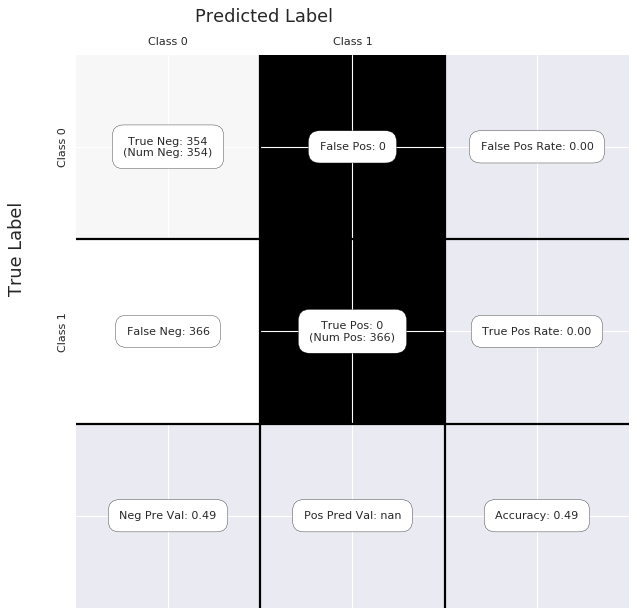

In [18]:
dl_functions.show_confusion_matrix(confusion_matrix(y_test, predicted_images_1), ['Class 0', 'Class 1'])

In [19]:
pd.DataFrame(confusion_matrix(y_test,predicted_images_1),columns = ['nok_image','ok_image'])

,nok_image,ok_image
0,354,0
1,366,0


In [20]:
predictions_probability_1 = model_1.predict_proba(X_test)

720/720 [==============================] - 11s    


#### Plotting a ROC curve.

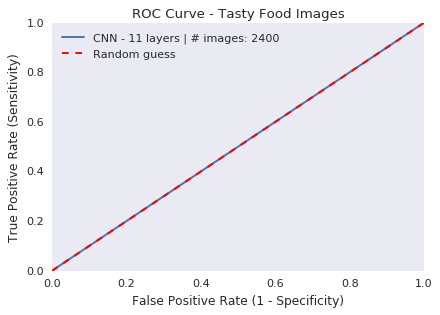

In [21]:
dl_functions.plot_roc(y_test, predictions_probability_1[:,1], "CNN - " + str(len(model_1.layers)) + " layers | # images: " + str(len(X)), "Tasty Food Images")

### Now, let's pre-process images without normalizing color.

In [22]:
X = np.vstack((dl_functions.create_images_array(ok_images, IMG_SIZE, False), dl_functions.create_images_array(nok_images, IMG_SIZE, False)))/255.

In [23]:
y = np.vstack((np.array([1]*(len(X)/2)).reshape((len(X)/2), 1), np.array([0]*(len(X)/2)).reshape((len(X)/2), 1)))

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [25]:
y_train_sparse = np_utils.to_categorical(y_train, 2)

In [26]:
y_test_sparse = np_utils.to_categorical(y_test, 2)

In [27]:
model_2 = dl_functions.cnn_model_baseline(IMG_SIZE)

In [28]:
model_2.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [29]:
model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 3, 250, 32)        72032     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 1, 248, 32)        9248      
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 248, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 1, 248, 64)        18496     
_________________________________________________________________
dropout_6 (Dropout)          (None, 1, 248, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 1, 248, 128)       73856     
_________________________________________________________________
dropout_7 (Dropout)          (None, 1, 248, 128)       0         
__________

In [30]:
model_2.fit(X_train, y_train_sparse, batch_size=128, epochs=20, verbose=1, validation_split=0.3)

Train on 1176 samples, validate on 504 samples
Epoch 1/20
1176/1176 [==============================] - 95s - loss: 6.4125 - acc: 0.4974 - val_loss: 8.2509 - val_acc: 0.4881
Epoch 2/20
1176/1176 [==============================] - 66s - loss: 8.0590 - acc: 0.5000 - val_loss: 8.2509 - val_acc: 0.4881
Epoch 3/20
1176/1176 [==============================] - 65s - loss: 8.0590 - acc: 0.5000 - val_loss: 8.2509 - val_acc: 0.4881
Epoch 4/20
1176/1176 [==============================] - 62s - loss: 8.0590 - acc: 0.5000 - val_loss: 8.2509 - val_acc: 0.4881
Epoch 5/20
1176/1176 [==============================] - 62s - loss: 8.0590 - acc: 0.5000 - val_loss: 8.2509 - val_acc: 0.4881
Epoch 6/20
1176/1176 [==============================] - 68s - loss: 8.0590 - acc: 0.5000 - val_loss: 8.2509 - val_acc: 0.4881
Epoch 7/20
1176/1176 [==============================] - 61s - loss: 8.0590 - acc: 0.5000 - val_loss: 8.2509 - val_acc: 0.4881
Epoch 8/20
1176/1176 [==============================] - 67s - loss: 8.0

In [31]:
score_2 = model_2.evaluate(X_test, y_test_sparse, verbose=1)

720/720 [==============================] - 14s    


In [32]:
print('Test loss: {:0,.4f}'.format(score_2[0]))
print('Test accuracy: {:.2%}'.format(score_2[1]))

Test loss: 7.9247
Test accuracy: 50.83%


In [33]:
predicted_images_2 = []
for i in model_2.predict(X_test):
  predicted_images_2.append(np.where(np.max(i) == i)[0])

dl_functions.py:181: RuntimeWarning: invalid value encountered in divide
  'Neg Pre Val: %.2f'%(1-fn/(fn+tn+0.)),


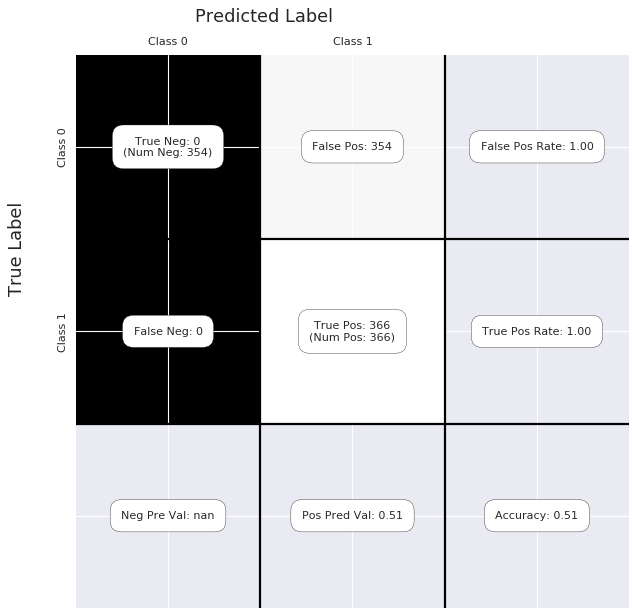

In [34]:
dl_functions.show_confusion_matrix(confusion_matrix(y_test, predicted_images_2), ['Class 0', 'Class 1'])

In [35]:
predictions_probability_2 = model_2.predict_proba(X_test)

720/720 [==============================] - 13s    


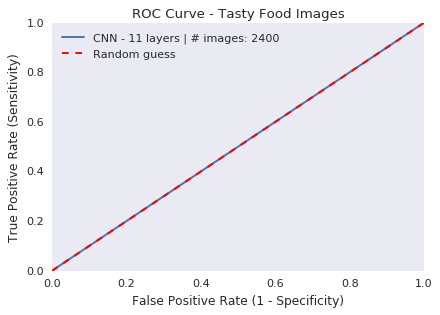

In [36]:
dl_functions.plot_roc(y_test, predictions_probability_2[:,1], "CNN - " + str(len(model_2.layers)) + " layers | # images: " + str(len(X)), "Tasty Food Images")

### Prediction using an image of Donald Trump.
<img src='images/trump_1.jpg' />

In [37]:
trump_1 = np.array(dl_functions.preprocess_img(io.imread('images/trump_1.jpg'), IMG_SIZE, True), dtype='float32')

In [38]:
trump_exp_1 = np.expand_dims(trump_1, axis=0)

In [39]:
trump_prediction_1 = model_1.predict_classes(trump_exp_1)

1/1 [==============================] - 2s


In [40]:
trump_prediction_1[0]

0

In [41]:
trump_2 = np.array(dl_functions.preprocess_img(io.imread('images/trump_1.jpg'), IMG_SIZE, False), dtype='float32')

In [42]:
trump_exp_2 = np.expand_dims(trump_2, axis=0)

In [43]:
trump_prediction_2 = model_2.predict_classes(trump_exp_2)

1/1 [==============================] - 0s


In [44]:
trump_prediction_2[0]

1

#### The model predicts the image as bad.

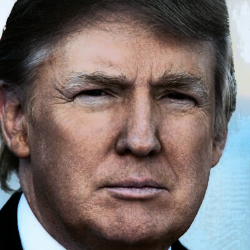

In [45]:
img_1 = array_to_img(trump_1, data_format='channels_first')
display(img_1)

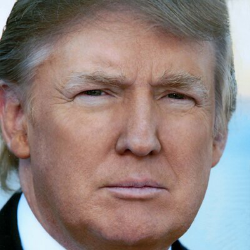

In [46]:
img_2 = array_to_img(trump_2, data_format='channels_first')
display(img_2)